In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-03 13:19:53


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from invisible_cities.database import load_db

In [14]:
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units

In [6]:
from plot_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, plot_signal_vs_time_mus,\
                           plot_s12, hist_1d

In [7]:
from event_pmaps import EventPmaps, print_s12, print_s2si

In [8]:
def plot_s12(S12):
    """Plot the peaks of input S12.

    S12 is a dictionary
    S12[i] for i in keys() are the S12 peaks
    """
    plt.figure(figsize=(6, 6))

    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "S12 (pes)")
    xy = len(S12)
    if xy == 1:
        t = S12[0][0]
        E = S12[0][1]
        ax1 = plt.subplot(1, 1, 1)
        ax1.plot(t, E)
    else:
        x = 3
        y = xy/x
        if y % xy != 0:
            y = int(xy/x) + 1
        for i in S12.keys():
            ax1 = plt.subplot(x, y, i+1)
            t = S12[i][0]
            E = S12[i][1]
            plt.plot(t, E)

In [9]:
run_number = 3389

In [10]:
DataPMT = load_db.DataPMT(run_number)

In [11]:
RWF_file = os.path.join(os.environ['IC_DATA'],
                        'LSC/wvfms/{}/dst_waves.gdcsnext.000_{}.root.h5'.format(run_number, run_number))


In [12]:
h5rwf = tb.open_file(RWF_file,'r')

In [15]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [16]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 163
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


In [17]:
s1par  = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=5, lmax=20, stride=4, rebin=False)
s2par = S12Params(tmin=640*units.mus, tmax=800*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=0.5 * units.pes,  thr_s2=1 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)

In [18]:
epm = EventPmaps(run_number,
                 s1par, s2par, thr,
                 verbose=True)

In [19]:
event=0
epm.calibrated_pmt_and_csum(event, pmtrwf)

7477.3421116275758

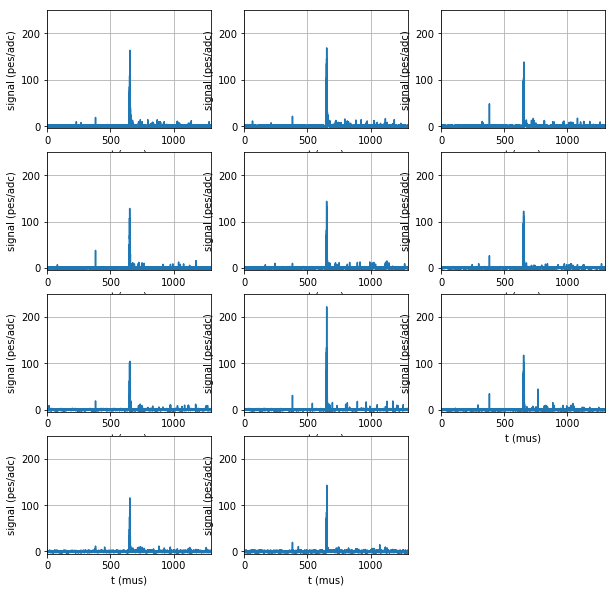

In [20]:
mpl.plot_pmt_signals_vs_time_mus(epm.CWF,
                                 epm.P.pmt_active,
                                 t_min      =    0,
                                 t_max      = 1300,
                                 signal_min =    -5,
                                 signal_max =  250)

There is a large S1 at around 400 mus. This is too large for the S2 and may be a hint of the issues we are facing.

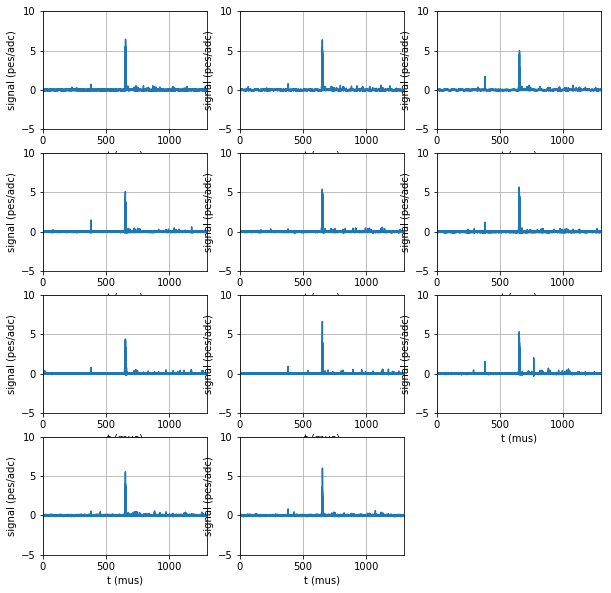

In [21]:
mpl.plot_pmt_signals_vs_time_mus(epm.CAL_PMT,
                             epm.P.pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -5,
                             signal_max =  10)

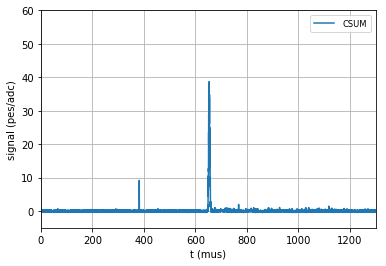

In [22]:
mpl.plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-5, 
                            signal_max=60, label='CSUM')

The height of "S1" is totally inconsistent with S2. What we have here is an event with an S1 of unknown origin and an S2 probably without S1. 

In [23]:
epm.find_s1()

number of peaks = 1
S12 number = 0, samples = 17 sum in pes =58.61823131191956
time vector (mus) = [ 381.675  381.7    381.725  381.75   381.775  381.8    381.825  381.85
  381.875  381.9    381.925  381.95   381.975  382.     382.075  382.1
  382.125]
energy vector (pes) = [ 1.61917637  4.26629217  7.76816226  9.1865877   8.86180842  7.24039865
  5.02407006  3.78509372  2.95172416  1.79096222  1.56561245  1.40410572
  0.902514    0.53159509  0.54448564  0.67117998  0.50446272]


1

An example of non-sense S1, at 60 pes. 

In [24]:
epm.find_s2()

number of peaks = 1
S12 number = 0, samples = 12 sum in pes =7002.0556670851765
time vector (mus) = [ 648.611875    649.6875      650.6875      651.6875      652.6875
  653.6875      654.6875      655.6875      656.6875      657.6875
  658.6925      659.72142857]
energy vector (pes) = [   92.34185897   305.01491887   609.24077745   986.05036791  1146.15608197
  1197.89848084  1079.29428206   699.55456278   539.60781327   262.37786222
    76.06448758     8.45417316]


1

S2 has 7,000 pes, could be consistent with Krypton, but possibly is not (Krypton is probably around 6300 pes). 

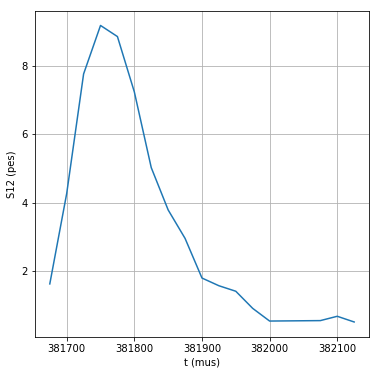

In [25]:
plot_s12(epm.S1)

In [26]:
epm.s1f

{0: S12Features(tmin=381675.0, tmax=382125.0, tpeak=381750.0, etot=58.618231311919558, epeak=9.1865877002908576, er=0.15671895065218108)}

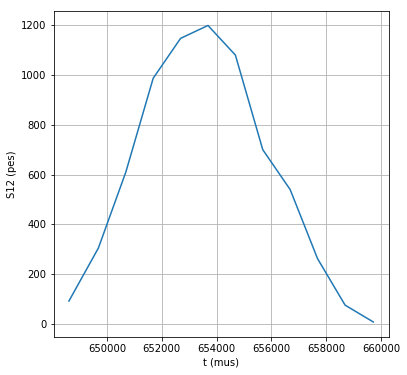

In [27]:
plot_s12(epm.S2)

In [28]:
epm.s2f

{0: S12Features(tmin=648611.875, tmax=659721.42857142852, tpeak=653687.5, etot=7002.0556670851765, epeak=1197.8984808434586, er=0.17107811445636809)}

In [29]:
epm.find_ns1()

11

In [30]:
dt = epm.s2f[0].tpeak - epm.s1f[0].tpeak

In [31]:
dt/units.mus

271.9375

In [ ]:
s1par  = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=3, lmax=10, stride=4, rebin=False)

In [32]:
event=1
epm.calibrated_pmt_and_csum(event, pmtrwf)

4470.9728598589736

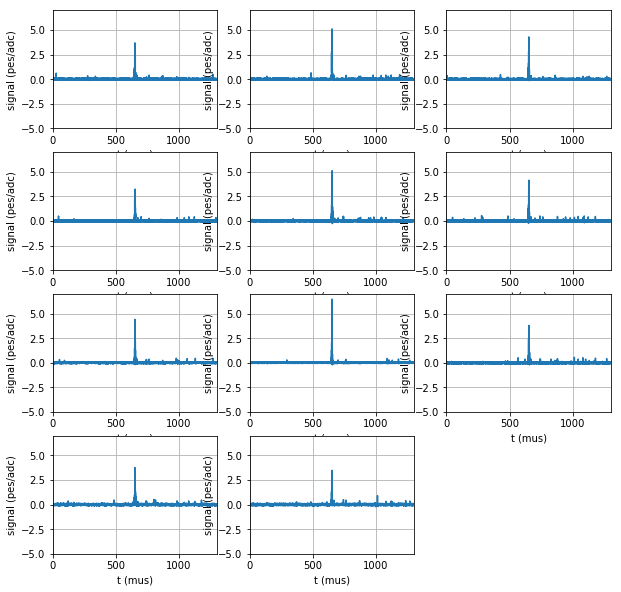

In [33]:
mpl.plot_pmt_signals_vs_time_mus(epm.CAL_PMT,
                             epm.P.pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -5,
                             signal_max =  7)

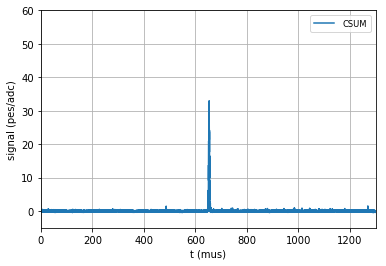

In [34]:
mpl.plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-5, 
                            signal_max=60, label='CSUM')

In [35]:
epm.find_s1()
epm.find_s2()
epm.find_ns1()

number of peaks = 1
S12 number = 0, samples = 8 sum in pes =7.0429711491779035
time vector (mus) = [ 486.325  486.35   486.375  486.4    486.425  486.45   486.475  486.5  ]
energy vector (pes) = [ 1.00572392  1.42807619  1.39077321  0.71169641  0.55596226  0.58390724
  0.71341985  0.65341206]
number of peaks = 1
S12 number = 0, samples = 10 sum in pes =4310.023342412648
time vector (mus) = [ 648.969375  650.0125    651.0125    652.0125    653.0125    654.0125
  655.0125    656.018125  657.175     658.4     ]
energy vector (pes) = [   79.10731397   225.66393013   579.11896605   848.53140956  1040.56168527
   821.1740507    424.45342996   209.32054645    78.80667266     3.28533765]


6

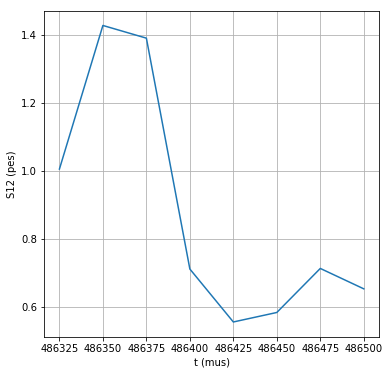

In [36]:
plot_s12(epm.S1)

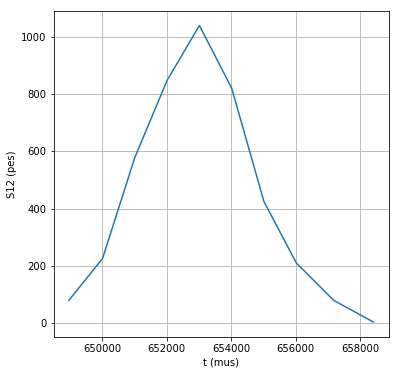

In [37]:
plot_s12(epm.S2)

In [38]:
epm.s1f

{0: S12Features(tmin=486325.0, tmax=486500.0, tpeak=486350.0, etot=7.0429711491779035, epeak=1.428076189953053, er=0.20276615645653273)}

This looks like a background event in conjunction with electron rain

In [ ]:
epm.s2f

In [39]:
event=2
epm.calibrated_pmt_and_csum(event, pmtrwf)
epm.find_s1()
epm.find_s2()
epm.find_ns1()

number of peaks = 1
S12 number = 0, samples = 10 sum in pes =10.06058866579143
time vector (mus) = [ 560.675  560.7    560.725  560.75   560.775  560.8    560.825  560.85
  560.875  560.9  ]
energy vector (pes) = [ 0.84893146  1.32635039  1.54025639  1.70296851  1.44951232  0.80352272
  0.6222865   0.62544253  0.62955583  0.51176201]
number of peaks = 1
S12 number = 0, samples = 7 sum in pes =5998.549626354456
time vector (mus) = [ 649.65125     650.6625      651.6625      652.6625      653.6625
  654.6625      655.65428571]
energy vector (pes) = [  155.58696218   567.92918747  1352.22258818  1844.07750461  1357.22038376
   585.98580281   135.52719735]


8

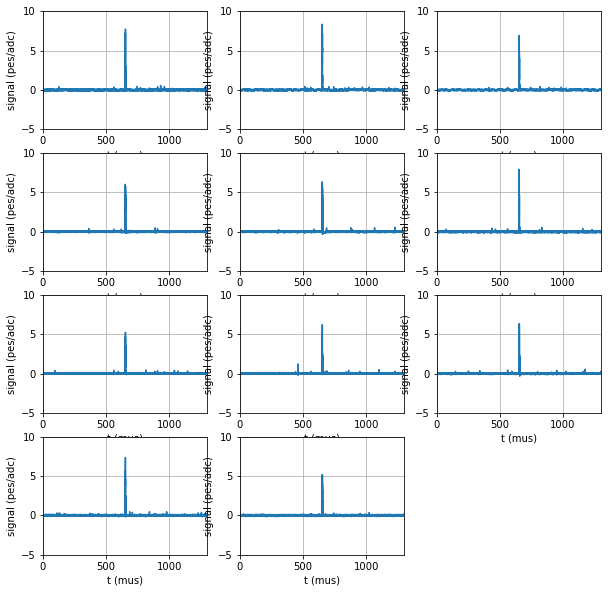

In [40]:
mpl.plot_pmt_signals_vs_time_mus(epm.CAL_PMT,
                             epm.P.pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -5,
                             signal_max =  10)

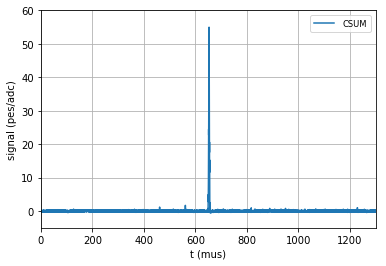

In [41]:
mpl.plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-5, 
                            signal_max=60, label='CSUM')

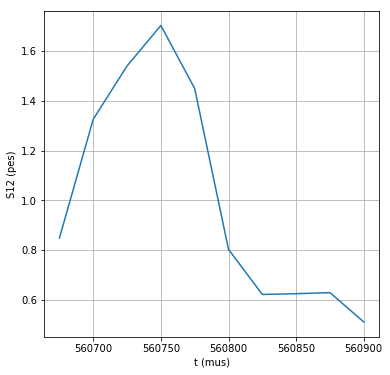

In [42]:
plot_s12(epm.S1)

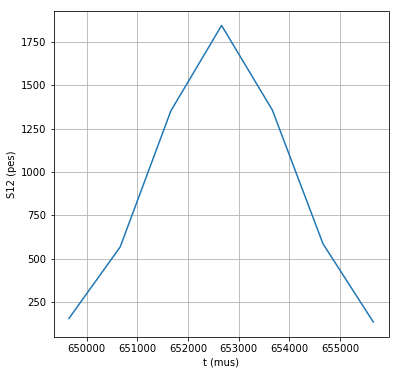

In [43]:
plot_s12(epm.S2)

In [44]:
epm.s1f

{0: S12Features(tmin=560675.0, tmax=560900.0, tpeak=560750.0, etot=10.06058866579143, epeak=1.7029685104258137, er=0.16927125906820356)}

In [45]:
epm.s2f

{0: S12Features(tmin=649651.25, tmax=655654.28571428568, tpeak=652662.5, etot=5998.5496263544564, epeak=1844.0775046144352, er=0.30742056321623701)}

In [46]:
def pmp(epm, event):
    epm.calibrated_pmt_and_csum(event, pmtrwf)
    
    mpl.plot_signal_vs_time_mus(epm.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-5, 
                            signal_max=60, label='CSUM')

    plt.show()
    print('+++S2+++++')
    epm.find_s2()
    if len(epm.S2) != 1:
        print('S2 not = 1')
        return 0
    plot_s12(epm.S2)
    plt.show()
    print('s2f = {} '.format(epm.s2f[0]))
    
    print('+++S1+++++')
    epm.find_s1()
    if len (epm.S1) == 0:
        print('S1 == 0')
        return 0
    
    plot_s12(epm.S1)
    
    for peak in epm.s1f:
        print('s1f = {} '.format(epm.s1f[peak]))
        dt = epm.s2f[0].tpeak - epm.s1f[peak].tpeak
        print('dt = {} mus'.format(dt/units.mus))
    

In [47]:
def pmp_plot(epmx):
    mpl.plot_pmt_signals_vs_time_mus(epmx.CAL_PMT,
                             epmx.P.pmt_active,
                             t_min      =    0,
                             t_max      = 1300,
                             signal_min =    -5,
                             signal_max =  10)
    plt.show()
    mpl.plot_signal_vs_time_mus(epmx.csum, 
                            t_min=0, 
                            t_max=1300, 
                            signal_min=-5, 
                            signal_max=60, label='CSUM')
    plt.show()
    plot_s12(epmx.S1)
    plt.show(
    plot_s12(epmx.S2))
    plt.show()

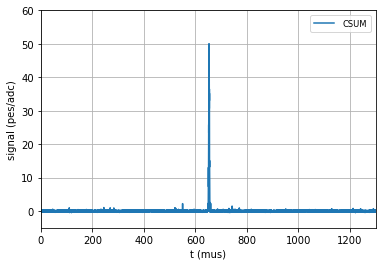

+++S2+++++
number of peaks = 1
S12 number = 0, samples = 7 sum in pes =5904.074327884989
time vector (mus) = [ 649.68125    650.6875     651.6875     652.6875     653.6875     654.6875
  655.7025641]
energy vector (pes) = [  125.19195543   496.02481193  1302.19767758  1819.04647729  1458.41380528
   552.0093494    151.19025097]


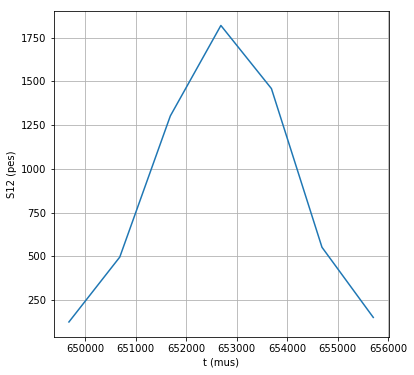

s2f = S12Features(tmin=649681.25, tmax=655702.56410256412, tpeak=652687.5, etot=5904.0743278849886, epeak=1819.0464772855908, er=0.30810019933086213) 
+++S1+++++
number of peaks = 1
S12 number = 0, samples = 7 sum in pes =9.029172133120799
time vector (mus) = [ 549.95   549.975  550.     550.025  550.05   550.075  550.1  ]
energy vector (pes) = [ 0.79413851  1.59442488  2.14860128  1.88534027  1.22456531  0.69365962
  0.68844227]
s1f = S12Features(tmin=549950.0, tmax=550100.0, tpeak=550000.0, etot=9.0291721331207988, epeak=2.1486012793157121, er=0.23796215728729053) 
dt = 102.6875 mus


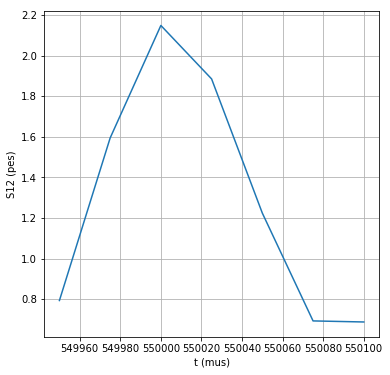

In [48]:
pmp(epm,event=3)

S1 has large er which may be distinctive of ER

In [ ]:
s1par  = S12Params(tmin=100*units.mus, tmax=500*units.mus, lmin=4, lmax=10, stride=4, rebin=False)
thr    = ThresholdParams(thr_s1=0.5 * units.pes,  thr_s2=1 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 20 * units.adc)
epm2 = EventPmaps(run_number,
                 s1par, s2par, thr,
                 verbose=True)

In [ ]:
pmp(epm2,event=3)

In [ ]:
pmp(epm,event=4)

In [ ]:
pmp(epm,event=5)

In [ ]:
pmp(epm,event=6)

In [ ]:
pmp(epm,event=8)

In [ ]:
pmp(epm,event=9)

In [ ]:
pmp(epm2,event=10)

In [ ]:
pmp(epm2,event=11)

In [ ]:
pmp(epm,event=12)

In [ ]:
gui.add_figure('s1 peaks ',hist_1d(epm.s1f.peak(), xlo=0, xhi=max(epm.s1f.peak()) + 1))
gui.add_figure('s1 width in ns',hist_1d(epm.s1f.width(), xlo=0, xhi=500))
gui.add_figure('s1 t in mus',hist_1d(epm.s1f.tpeak()/units.mus, xlo=0, xhi=650))
gui.add_figure('s1 etot in pes',hist_1d(epm.s1f.etot(), xlo=0, xhi=max(epm.s1f.etot())+10))
gui.add_figure('s1 etot in pes (2)',hist_1d(epm.s1f.etot(), xlo=0, xhi=50))
gui.add_figure('s1 emax in pes',hist_1d(epm.s1f.emax(), xlo=0, xhi=max(epm.s1f.emax())+10))
gui.add_figure('s1 emax/etot in pes',hist_1d(epm.s1f.emax_over_etot(), xlo=0, xhi=1))

In [ ]:
gui.add_figure('s2 peaks ',hist_1d(epm.s2f.peak(), xlo=0, xhi=max(epm.s2f.peak()) + 1))
gui.add_figure('s2 width in mua',hist_1d(epm.s2f.width()/units.mus, xlo=0, xhi=max(epm.s2f.width()/units.mus)+10))
gui.add_figure('s2 t in mus',hist_1d(epm.s2f.tpeak()/units.mus, xlo=650, xhi=670))
gui.add_figure('s2 etot in pes',hist_1d(epm.s2f.etot(), xlo=0, xhi=max(epm.s2f.etot())+100))
gui.add_figure('s2 emax in pes',hist_1d(epm.s2f.emax(), xlo=0, xhi=max(epm.s2f.emax())+100))
gui.add_figure('s2 emax/etot in pes',hist_1d(epm.s2f.emax_over_etot(), xlo=0, xhi=1))